## Part 1- Exploratory Data Analysis
The logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Using this dataset;
- aggregate these login counts based on 15minute time intervals.
- visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. 
- report/illustrate important features of the demand, such as daily cycles.
- report data quality issues if there is any.

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import pickle
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, cv, plot_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, mean_squared_error

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support, plot_precision_recall_curve, balanced_accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score

# Hypermeter tuning packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

import pickle

In [2]:
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df.shape

(93142, 1)

In [4]:
df.dtypes

login_time    datetime64[ns]
dtype: object

In [5]:
# Print first and last login data
print(f'First login: {min(df.login_time)}')
print(f'Last login: {max(df.login_time)}')

First login: 1970-01-01 20:12:16
Last login: 1970-04-13 18:57:38


In [6]:
# add a column to represent the number of logins during each time
df['num_logins'] = 1
# convert the date to a datetime object, and set it as the index
df = df.set_index(pd.to_datetime(df['login_time'], unit='s'))[['num_logins']]
df.head()

,num_logins
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [7]:
# Aggregate these login counts based on 15 minute time intervals
df15 = df.resample('15min').sum()
df15.head()

,num_logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


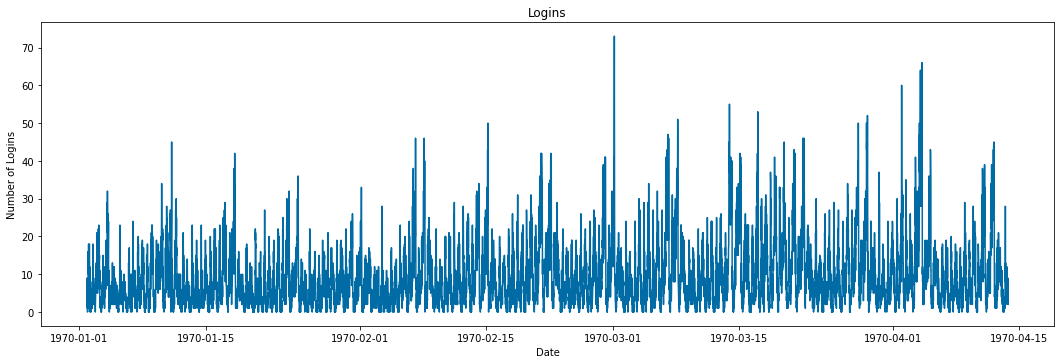

In [8]:
# scatterplot of the binned data
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Date')
plt.ylabel('Number of Logins')
plt.tight_layout()
plt.title('Logins')
# puts the data in the figure
plt.plot(df15.index, df15.num_logins)

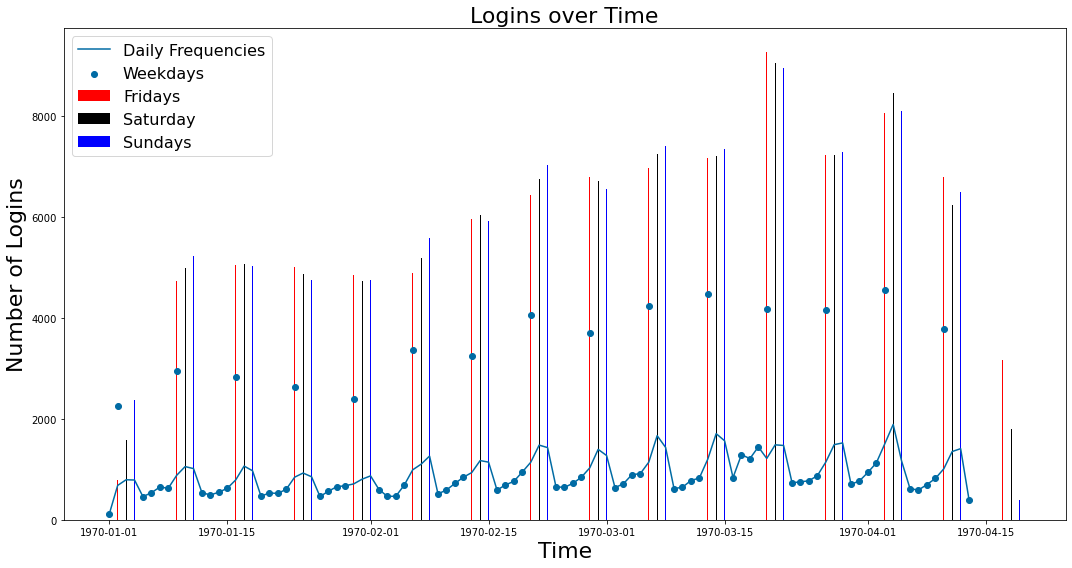

In [9]:
# bin data by the day
logins_daily = df.resample('D').sum()
logins_biz_day = df.resample('B').sum()
fridays = df.resample('W-FRI').sum()
saturdays = df.resample('W-SAT').sum()
sundays = df.resample('W-SUN').sum()


# line, scatterplot, and histograms of the binned data
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)

colors = ["red","green","blue","white","yellow","magenta","cyan", 'black']
plt.bar(fridays.index, fridays.num_logins, align= 'center', width = 0.1, label = "Fridays", color = 'red')
plt.bar(saturdays.index, saturdays.num_logins, label = 'Saturday', align = 'center', width = 0.1, color = 'black')
plt.bar(sundays.index, sundays.num_logins, label = "Sundays", align= 'center', width = 0.1, color = 'blue')
plt.plot(logins_daily.index, logins_daily.num_logins, label = 'Daily Frequencies')
plt.scatter(logins_biz_day.index, logins_biz_day.num_logins, label='Weekdays')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()

Compared to weekdays, logins on Fridays, Saturdays and Sundays have higher trends. There is also a specific surge in logings at the third week of March and the second week of April.

In [10]:
# resample index hourly
daily_logins = df.resample('H').sum()
# make a column that identify the day of week; Monday=0, Sunday=6
day_of_week = list(daily_logins.index.dayofweek)
daily_logins['day_of_week'] = day_of_week
# add column with just the hour (omiting the date)
daily_logins['hour'] = [time.hour for time in daily_logins.index]

In [11]:
# create dataframe of the average number of logins for each hour of each day
avg_hourly_logins = pd.pivot_table(daily_logins, values = 'num_logins', index = 'hour', columns = 'day_of_week', aggfunc=np.mean).rename(columns= {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
# stack
avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])
# name the stack
avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()

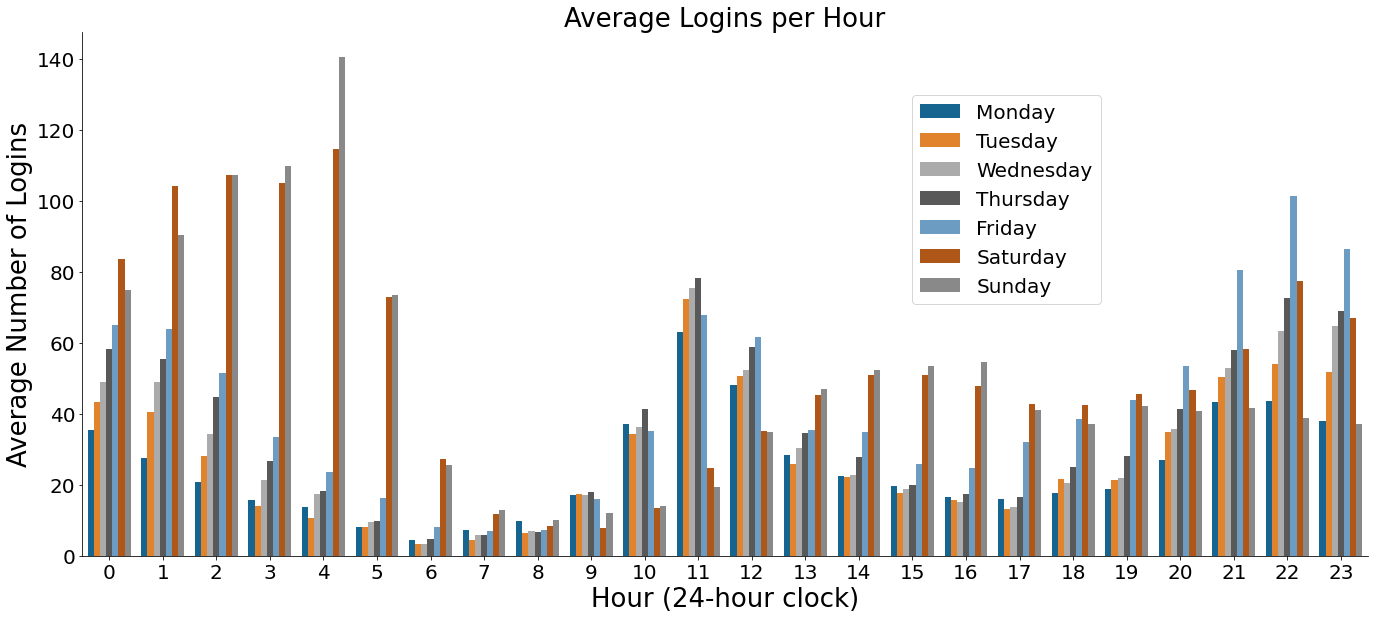

In [12]:
# plot average hourly use
sns.catplot(x='hour', y='avg_num_logins', data=avg_hourly_logins_df, kind = 'bar', 
            hue='day_of_week',height=8, aspect=11.7/5, legend=False)
ax = plt.gca()
ax.set_title('Average Logins per Hour', fontsize = 26)
ax.set_xlabel('Hour (24-hour clock)', fontsize = 26)
ax.set_ylabel('Average Number of Logins', fontsize = 26)
ax.tick_params(labelsize=20,labelcolor="black")
ax.legend(bbox_to_anchor=(0.7,0.7,0.1, 0.2),fontsize=20)

During weekdays, there is a significant increase in demands during lunchtime and in the evenings until 3 am in the morning. On Fridays, there is a significant spike in login counts between 8 pm and 3 am significantly. This trend is similar for Saturdays and Sundays, but we observe higher traffic between 12 am and 6 am on weekends. 

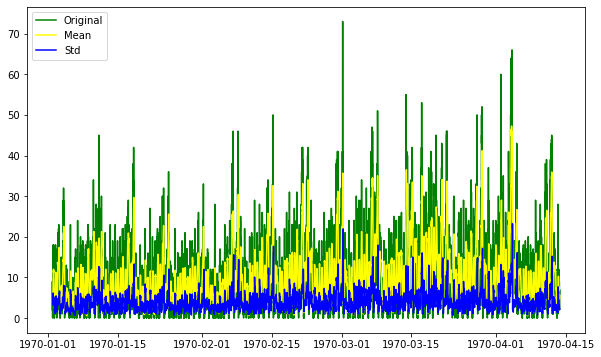

In [13]:
# plot mean and std
plt.figure(figsize=(10,6))
rolmean = df15['num_logins'].rolling(window=12).mean()
rolstd = df15['num_logins'].rolling(window=12).std()
orig = plt.plot(df15['num_logins'], color='green', label='Original')
mean = plt.plot(rolmean, color='yellow', label='Mean')
std = plt.plot(rolstd, color='blue', label='Std')
plt.legend(loc='best')
plt.title = ("Rolling mean and STD")
plt.show(block=False)

In [14]:
# checking the stationarity of the data by using adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df15['num_logins'])

Results of Dickey-Fuller Test:
Test Statistic                -1.033795e+01
p-value                        2.732397e-18
#Lags Used                     3.800000e+01
Number of Observations Used    9.749000e+03
Critical Value (1%)           -3.431021e+00
Critical Value (5%)           -2.861837e+00
Critical Value (10%)          -2.566928e+00
dtype: float64


According to the results of Dickey-Fuller Test, the test statistic is lower than critical values and the p-vlaue is lower than .05. This means the data is stationary. Therefore, the data does not need transformation and in general, there is no significant issue related to the dataset.

## Part 2 - Experiment and Metrics Design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

<b> Answer: To evaluate the effectiveness of the reimbursement program, I would use the average number of drivers during daytime and nighttime on weekdays in each city as the main metric. This key measure can be analyzed using a one-tailed t-test to determine any significant differences in the availability of drivers between Gotham and Metropolis.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. 

Please provide details on:

a) how you will implement the experiment
   
<b> To establish a baseline before implementing the reimbursement program, I would initially calculate the average number of available drivers in both cities during the previous month. This baseline value can serve as a reference point for comparing the key metrics after the intervention. To track the number of available drivers in each city during the following month, I would utilize toll bridge recording systems such as cameras, scanners, or human-directed systems. Additionally, I would record the entry times of the drivers as a control variable, allowing us to analyze their availability during daytime and nighttime in each city. Then I would test the following hypothesis using one-tailed t-test:
    
    H0: Between the pre and post-reimbursement program periods, there is no significant difference in the mean number of available drivers entering from Gotham to Metropolis on weekdays from 6:00 AM to 7:00 PM.
    
    H1: Between the pre and post-reimbursement program periods, there is an increase in the mean number of available drivers entering from Gotham to Metropolis on weekdays from 6:00 AM to 7:00 PM.
    
    H0: Between the pre and post-reimbursement program periods, there is no significant difference in the mean number of available drivers entering from Metropolis to Gotham on weekdays from 8:00 PM to 6:00 AM.
    
    H2: Between the pre and post-reimbursement program periods, there is an increase in the mean number of available drivers entering from Metropolis to Gotham on weekdays from 8:00 PM to 6:00 AM.
    
b) what statistical test(s) you will conduct to verify the significance of the observation

<b> I would use one-tailed t-test because it will allow us to test any significant differences in the availability of drivers between Gotham and Metropolis.
    
c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

<b> We can check the p-value of the test statistics to evaluate each hypothesis. If the p-value obtained from the t-test is less than 0.05, we can conclude that the reimbursement program has been successful in increasing the number of available drivers in that city (H1: Metropolis, H2:Gotham). 
    Conversely, if the p-value is higher than 0.05, we can conclude that there is no significant difference in driver availability between the period before and after the implementation of the reimbursement program. Therfore, reimbursement program needs to be reconsidered. 

## Part 3 - Predictive Modeling
Predicting rider retention. 
   - retained users: took a trip in the preceding 30 days.

1. Data cleaning, wrangling, and visualization. What fraction of the observed users were retained?

2. Predictive model to determine whether or not a user will be active in their 6th month on the system. How valid is your model?

3. Briefly discuss how Ultimate might leverage the insights gained from the model.


In [15]:
df2= pd.read_json('ultimate_data_challenge.json')
df2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [16]:
df2.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [17]:
df2.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [18]:
df2.avg_rating_of_driver = df2.avg_rating_of_driver.fillna(value=-1)
df2.avg_rating_by_driver = df2.avg_rating_by_driver.fillna(value=-1)
df2.phone = df2.phone.fillna(value='None')
df2.ultimate_black_user = df2.ultimate_black_user.astype('int')

In [19]:
# convert dates to datetime objects
df2['signup_date'] = pd.to_datetime(df2['signup_date'])
df2['last_trip_date'] = pd.to_datetime(df2['last_trip_date'])

In [20]:
df2.last_trip_date.describe(datetime_is_numeric=False)

C:\Users\Emine\AppData\Local\Temp\ipykernel_24956\2172826360.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df2.last_trip_date.describe(datetime_is_numeric=False)


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [21]:
# determine 30 days previous to the pull day
last_30_day = pd.to_datetime('2014-06-29') - pd.Timedelta('30 days')

In [22]:
# add customer status to dataframe 
df2['customer_status'] = (df2.last_trip_date > last_30_day).astype('int')

In [23]:
#0= inactive, 1 = active
active_customer=df2[df2.customer_status==1]
inactive_customer=df2[df2.customer_status==0]

In [24]:
# fraction of the active customers
pct = round((len(active_customer.customer_status)/len(df2.customer_status)) * 100)
print('{} percent of customers were retained.'.format(pct))

38 percent of customers were retained.


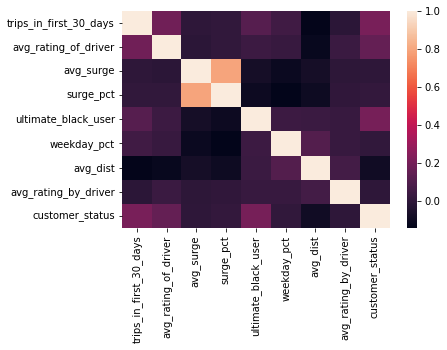

In [25]:
# checking the correlation
sns.heatmap(df2.corr())
plt.show()

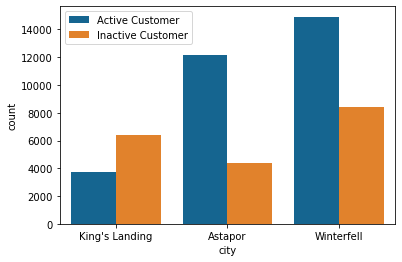

In [26]:
sns.countplot(x = 'city', data=df2, hue='customer_status')
plt.legend(loc='upper left', labels=['Active Customer', 'Inactive Customer'])
plt.show()

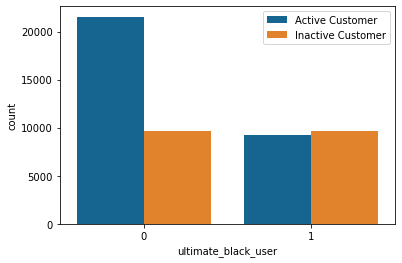

In [27]:
sns.countplot(x = 'ultimate_black_user', data=df2, hue='customer_status')
plt.legend(loc='upper right', labels=['Active Customer', 'Inactive Customer'])
plt.show()

In [28]:
# add dummies to categorical data
df2 = pd.get_dummies(df2, columns = ['city', 'phone'])
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']

In [29]:
# define features and target
X = df2[feature_columns]
y = df2.customer_status
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

In [30]:
# dictionary of parameters to optimize, and the range of optimization values
parameters = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.9],
    'subsample':[1,0.8],
    'learning_rate': [0.25, 0.2, 0.1],
    'min_child_weight':[0,1,2],
    'gamma':[1, 2, 3]
    }

In [31]:
# initiate the model
model_xgb = xgb.XGBClassifier(seed=0)  

# Scale both train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit model on scaled X_train data
model_xgb.fit(X_train_scaled, y_train)

# Call predict 
y_pred = model_xgb.predict(X_test_scaled) 

In [32]:
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.7792


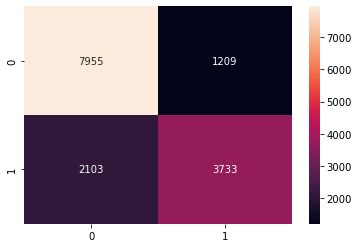

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

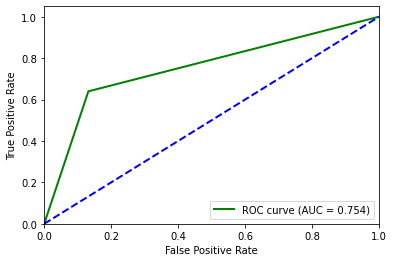

In [34]:
#ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='green',
         lw=lw, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [35]:
# Define random search
random_search = RandomizedSearchCV(estimator=model_xgb , 
                           param_distributions=parameters,
                           scoring = 'accuracy', 
                           n_jobs=-1, 
                           cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0), 
                           verbose=0)

# Fit grid search
random_result = random_search.fit(X_train_scaled, y_train)

In [36]:
# Print the best score and the corresponding hyperparameters
print('Best Score: %s' % random_result.best_score_)
print(f'The best hyperparameters are {random_result.best_params_}')

Best Score: 0.7783714739251676
The best hyperparameters are {'subsample': 1, 'scale_pos_weight': 0.95, 'min_child_weight': 1, 'max_delta_step': 0, 'learning_rate': 0.1, 'gamma': 2}


In [37]:
random_best = random_search.best_estimator_.fit(X_train_scaled,y_train)

y_pred = random_best.predict(X_test_scaled)

In [38]:
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.7797333333333333


There is no improvement in the accuracy of the model after hyperparameter optimization, so overfitting is still the issue in the data

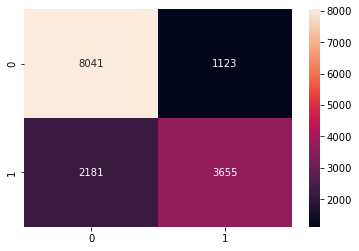

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

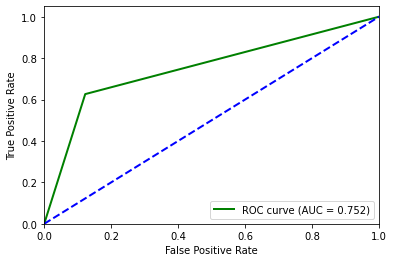

In [40]:
# Visualize the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='green',
         lw=lw, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [41]:
# train unoptimized model
model_xgb.fit(X_train, y_train)
# predict the labels of unoptimized model
y_pred = model_xgb.predict(X_train)
# score model
model_score = accuracy_score(y_train, y_pred)
# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(model_score,4)))

The resulting accuracy of the unoptimized classifier is 0.8253.


In [42]:
# train unoptimized model
model_xgb.fit(X, y)
# predict the labels of unoptimized model
y_pred = model_xgb.predict(X)
# score model
model_score = accuracy_score(y, y_pred)
# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(model_score,4)))

The resulting accuracy of the unoptimized classifier is 0.815.


We got better model accuracy.

In [43]:
# instantiate classifier
model_final = xgb.XGBClassifier(seed =0)
# train final model
model_final.fit(X, y)
# save model
pickle.dump(model_final, open('final_model.pickle', 'wb'))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

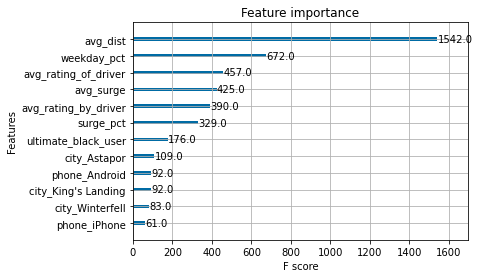

In [44]:
plot_importance(model_final)

Using default parameters while performing XGBoost model results better accuracy score (%82). Customer retention is heavyly affected by average distance in miles per trip in first 30 days after the sign up. 